## Косинского Никиты 
### 8 группа
### Лабараторные работы 4, 5
### Преподаватель: Полузеров Тимофей Дмитриевич

In [60]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv(r"D:\pProjects\lab_1\data\Annual 2005-2011.csv")
k_cols = [f'k{i}' for i in range(1, 21)]
X = df[k_cols].copy()
df.head()

,empl_num,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,k16,k17,k18,k19,k20,year
0,6095.0,0.942380,0.060563,0.678302,-0.161531,0.202055,0.165019,0.399033,0.799019,5.426569,0.209235,1.115922,1.082798,0.655937,4.454819,3.975687,0.892446,1007.536232,0.076738,0.055049,0.034904,5.0
1,255.0,1.980494,0.274382,0.916775,0.624425,0.089377,0.220648,0.000000,0.933519,14.041958,0.215083,1.259382,1.123828,0.705951,10.618881,12.295547,1.157895,357.294118,0.116068,0.059740,0.025647,5.0
2,114.0,0.374160,0.001494,0.085138,-1.504990,0.235739,0.508929,0.888889,0.779049,5.017007,0.096737,0.774586,1.185374,0.123415,0.794785,6.258929,7.875000,36.894737,-0.584879,0.010563,0.000000,5.0
3,365.0,7.859079,0.831978,2.449864,0.875862,0.059439,0.030030,0.011111,0.942010,16.244444,0.876663,1.223284,1.309449,2.804607,48.363889,26.142643,0.540541,33.676983,0.171731,0.496295,0.312415,5.0
4,168.0,1.779376,0.005596,0.883293,0.527853,0.135491,0.886686,0.489796,0.887341,10.558673,0.313389,0.874381,0.994832,0.473041,5.628827,3.125354,0.555241,19.103896,0.064809,0.025726,0.011839,5.0


## Масштабирование данных и кластеризация

In [61]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df["cluster"] = clusters
df["cluster"].value_counts()

cluster
0    1003
2     733
1     729
3     230
Name: count, dtype: int64

## График кластеров

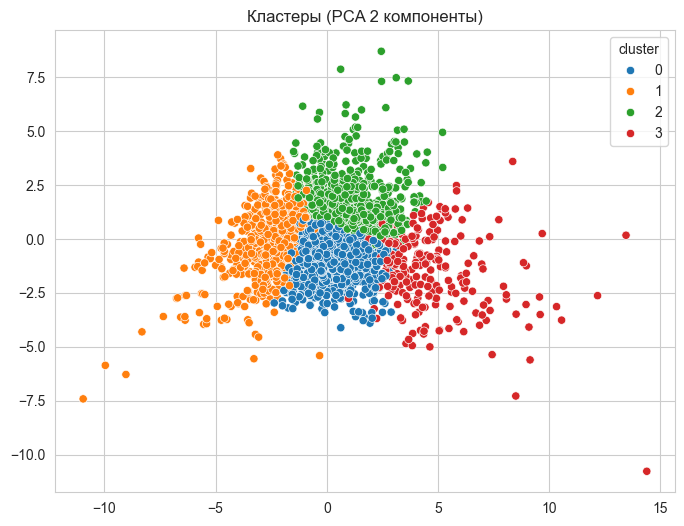

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], hue=df['cluster'], palette='tab10')
plt.title('Кластеры (PCA 2 компоненты)')
plt.show()

## Нумерация кластеров

In [63]:
cluster_means = df.groupby("cluster")[k_cols].mean().mean(axis=1)
mapping = {old: new for new, old in enumerate(cluster_means.sort_values(ascending=False).index, start=1)}
df["rating"] = df["cluster"].map(mapping)
df["rating"].value_counts()

rating
1    1003
3     733
4     729
2     230
Name: count, dtype: int64

## Задание 6. Дискриминантный анализ

## Формирование обучающей и экзаменационной выборок

In [64]:
test_df = df.groupby("rating", group_keys=False).apply(
    lambda x: x.sample(frac=0.10, random_state=42)
)

train_df = df.drop(test_df.index)

X_train = train_df[k_cols]
y_train = train_df["rating"]

X_test  = test_df[k_cols]
y_test  = test_df["rating"]
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

,solver,'svd'
,shrinkage,None
,priors,None
,n_components,None
,store_covariance,False
,tol,0.0001
,covariance_estimator,None


## Переклассификация обучающей выборки

In [65]:
train_pred = lda.predict(X_train)
print("Точность (переклассификация):", accuracy_score(y_train, train_pred))

pd.DataFrame(confusion_matrix(y_train, train_pred),
             index=['Real1','Real2','Real3','Real4'],
             columns=['Pred1','Pred2','Pred3','Pred4'])

Точность (переклассификация): 0.9179719703215169


,Pred1,Pred2,Pred3,Pred4
Real1,886,0,6,11
Real2,31,166,10,0
Real3,57,0,570,33
Real4,45,0,6,605


## Классификация экзаменационной выборки

In [66]:
test_pred = lda.predict(X_test)
print("Точность (экзаменационная выборка):", accuracy_score(y_test, test_pred))

pd.DataFrame(confusion_matrix(y_test, test_pred),
             index=['Real1','Real2','Real3','Real4'],
             columns=['Pred1','Pred2','Pred3','Pred4'])

Точность (экзаменационная выборка): 0.9330855018587361


,Pred1,Pred2,Pred3,Pred4
Real1,97,0,0,3
Real2,4,17,2,0
Real3,4,0,69,0
Real4,5,0,0,68


## Оценка ошибок (условные и безусловные)

In [67]:
# Условная вероятность ошибки для каждого класса
errors = []
for cls in sorted(y_train.unique()):
    cls_idx = y_train == cls
    err = 1 - accuracy_score(y_train[cls_idx], train_pred[cls_idx])
    errors.append(err)
    print(f"Класс {cls} ошибка = {err:.3f}")

# Безусловная
print("Безусловная ошибка =", 1 - accuracy_score(y_train, train_pred))

Класс 1 ошибка = 0.019
Класс 2 ошибка = 0.198
Класс 3 ошибка = 0.136
Класс 4 ошибка = 0.078
Безусловная ошибка = 0.0820280296784831


## Задание 7. Логит-модель множественного выбора

## Мультиномиальная логит‑модель

In [68]:
logit = LogisticRegression(
    multi_class='multinomial',
    max_iter=500,
    solver='lbfgs'
)

logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)

print("Точность мультиномиальной логит-функции:", accuracy_score(y_test, logit_pred))

pd.DataFrame(confusion_matrix(y_test, logit_pred),
             index=['Real1','Real2','Real3','Real4'],
             columns=['Pred1','Pred2','Pred3','Pred4'])

Точность мультиномиальной логит-функции: 0.7657992565055762


,Pred1,Pred2,Pred3,Pred4
Real1,90,1,5,4
Real2,4,18,1,0
Real3,13,0,57,3
Real4,11,1,20,41


## Коэффициенты логит‑модели

In [69]:
coef_df = pd.DataFrame(logit.coef_, columns=k_cols)
coef_df["Class"] = logit.classes_
coef_df

,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,k16,k17,k18,k19,k20,Class
0,-0.154876,-0.181368,-0.141515,0.220574,-0.068057,0.035519,-0.002071,0.166601,0.242960,-0.164638,0.032912,-0.039428,0.032185,-0.070173,0.042686,0.069995,0.000035,0.002461,-0.027712,-0.031710,1
1,0.233487,0.239859,0.222737,0.122450,-0.148137,-0.084647,-0.085919,-0.145780,0.245439,-0.230875,-0.375992,-0.387240,-0.215270,-0.025699,-0.020798,-0.427935,-0.000008,0.000378,0.003919,0.002706,2
2,0.029343,0.012724,0.016595,0.169460,-0.030022,-0.091061,-0.095521,0.019657,-0.355898,0.238341,0.214213,0.289280,0.189002,0.089045,0.038134,-0.076236,0.000022,0.062401,0.078008,0.111005,3
3,-0.107955,-0.071215,-0.097816,-0.512485,0.246216,0.140189,0.183510,-0.040479,-0.132500,0.157172,0.128867,0.137388,-0.005916,0.006827,-0.060021,0.434176,-0.000048,-0.065240,-0.054215,-0.082001,4


## Отчёт о качестве модели

In [70]:
print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

           1       0.76      0.90      0.83       100
           2       0.90      0.78      0.84        23
           3       0.69      0.78      0.73        73
           4       0.85      0.56      0.68        73

    accuracy                           0.77       269
   macro avg       0.80      0.76      0.77       269
weighted avg       0.78      0.77      0.76       269

